In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%reload_ext autoreload

In [5]:
from TargetDistributions.DoubleWell import ManyWellEnergy
from FittedModels.utils.plotting_utils import plot_samples_vs_contours_many_well

In [20]:
from FittedModels.Models.FlowModel import FlowModel
from AIS_train.train_AIS import AIS_trainer
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from FittedModels.utils.plotting_utils import plot_history, plot_distributions, plot_samples

import matplotlib.pyplot as plt
import torch
from Utils.plotting_utils import plot_func2D, plot_distribution
from Utils.numerical_utils import MC_estimate_true_expectation
from Utils.numerical_utils import quadratic_function as expectation_function
torch.set_default_dtype(torch.float64)

def plotter(*args, **kwargs):
    # wrap plotting function like this so it displays during training
    plot_samples_vs_contours_many_well(*args, **kwargs)
    plt.show()

In [21]:
dim = 2
target = ManyWellEnergy(dim=dim, a=-0.5, b=-6)

In [22]:
n_samples_expectation = int(1e4)
n_samples=int(1e4)

# Vanilla IS

In [9]:
learnt_sampler = FlowModel(x_dim=dim, scaling_factor=2.0, flow_type="RealNVP", n_flow_steps=60)
vanilla_IS = VanillaImportanceSampling(sampling_distribution=learnt_sampler, target_distribution=target)
with torch.no_grad():
    expectation_vanilla, info_dict_vanilla = \
    vanilla_IS.calculate_expectation(n_samples_expectation, expectation_function=expectation_function)
    print(f"ESS is {info_dict_vanilla['effective_sample_size']/n_samples_expectation}, \
          var is {torch.var(info_dict_vanilla['normalised_sampling_weights'])}")

ESS is 0.09001292181905043,           var is 1.0110527106531126e-07


# Annealed IS, KL objective

In [39]:
learnt_sampler = FlowModel(x_dim=dim, scaling_factor=2.0, flow_type="RealNVP", n_flow_steps=60)
tester = AIS_trainer(target, learnt_sampler, loss_type="kl", n_distributions=5, n_steps_transition_operator=5,
                    step_size=1.0, transition_operator="Metropolis", learnt_dist_kwargs={"lr": 1e-4})

In [40]:
tester.anneal_step_size

False

In [13]:
expectation_before, info_dict_before = tester.AIS_train.calculate_expectation(n_samples_expectation,
                                                                    expectation_function=expectation_function,
                                                                             batch_size=int(1e3))
print(info_dict_before['effective_sample_size'].item() / n_samples_expectation)

0.18378614219478062


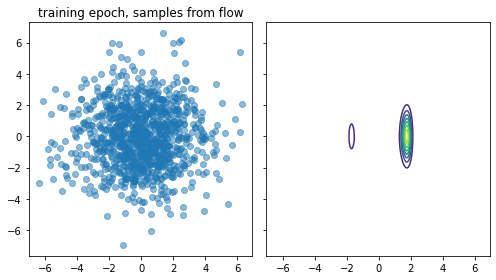

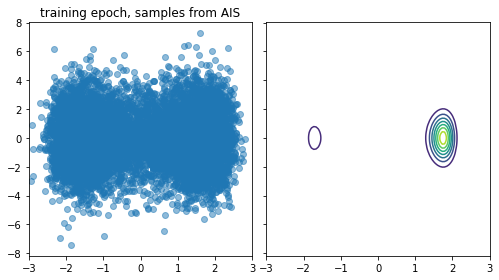

In [14]:
plot_samples_vs_contours_many_well(tester, n_samples=1000,
                                      title=f"training epoch, samples from flow")
plot_samples_vs_contours_many_well(tester, n_samples=None,
                                      title=f"training epoch, samples from AIS",
                                      samples_q=info_dict_before["samples"])

  0%|                                                                                                                                                          | 0/300 [00:00<?, ?it/s]

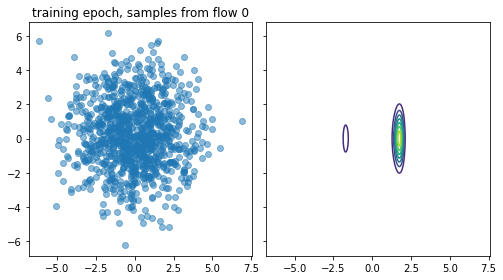

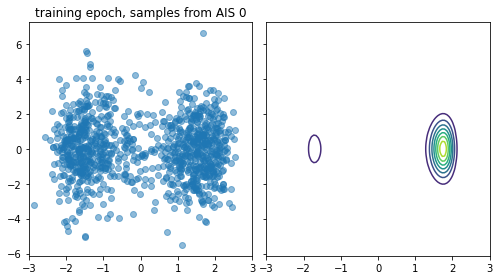

loss: -7.900705024808474,   log_p_x_post_AIS 4.890797821375126, ESS 0.2389259585366951:  25%|██████████████▎                                          | 75/300 [04:13<11:42,  3.12s/it]

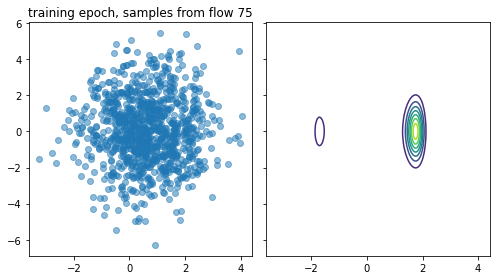

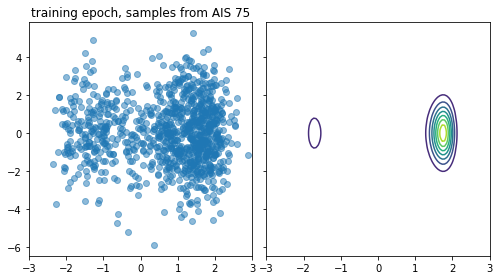

loss: -8.412526231553324,   log_p_x_post_AIS 5.780564320587903, ESS 0.2706221837024499:  50%|████████████████████████████                            | 150/300 [08:31<08:33,  3.42s/it]

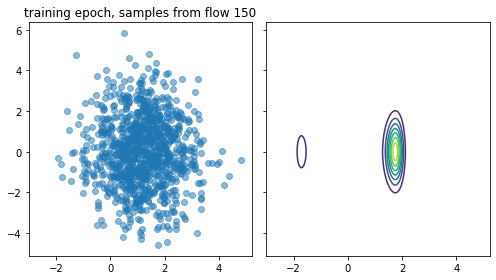

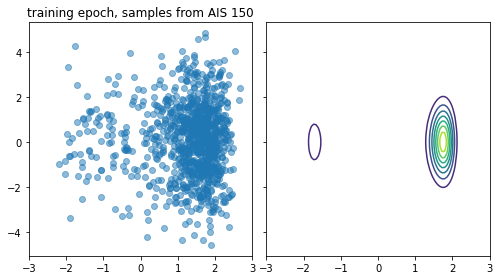

loss: -8.456118982043938,   log_p_x_post_AIS 5.85857281689164, ESS 0.24770189313242863:  75%|██████████████████████████████████████████              | 225/300 [12:37<03:52,  3.10s/it]

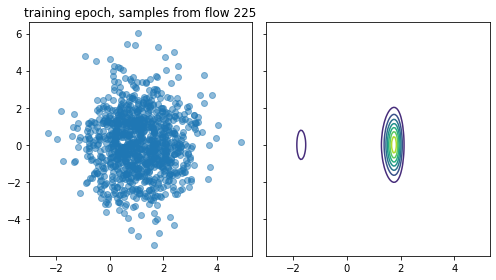

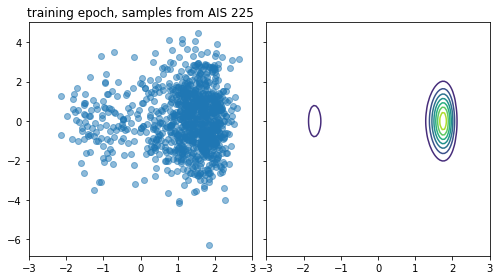

loss: -8.439965935873039,   log_p_x_post_AIS 5.839612681414927, ESS 0.20077782932429014: 100%|███████████████████████████████████████████████████████| 300/300 [16:30<00:00,  3.30s/it]


In [41]:
history = tester.train(300, batch_size=int(1e3), intermediate_plots=True, n_plots=4, plotting_func=plotter)

In [42]:
expectation, info_dict = tester.AIS_train.calculate_expectation(n_samples_expectation,
                                                                    expectation_function=expectation_function,
                                                                             batch_size=int(1e3))
print(info_dict['effective_sample_size'].item() / n_samples_expectation)

0.23766772030798683


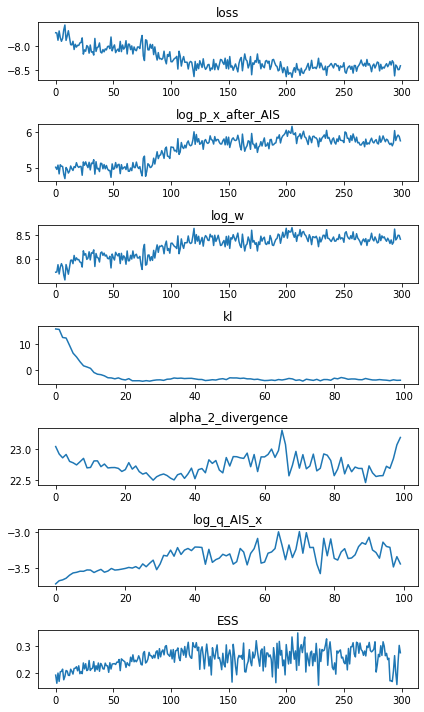

In [43]:
plot_history(history)

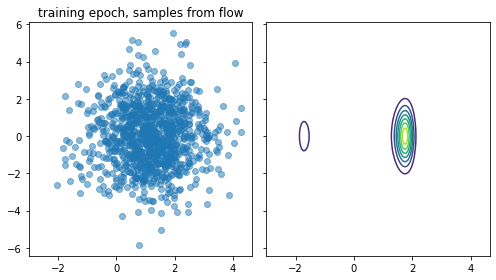

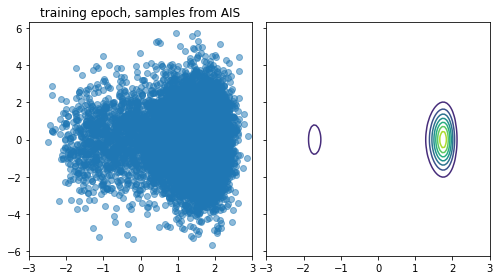

In [44]:
plot_samples_vs_contours_many_well(tester, n_samples=1000,
                                      title=f"training epoch, samples from flow")
plot_samples_vs_contours_many_well(tester, n_samples=None,
                                      title=f"training epoch, samples from AIS",
                                      samples_q=info_dict["samples"])

# Anneal Step Size KL objective

In [34]:
learnt_sampler = FlowModel(x_dim=dim, scaling_factor=2.0, flow_type="RealNVP", n_flow_steps=60)
tester = AIS_trainer(target, learnt_sampler, loss_type="kl", n_distributions=5, n_steps_transition_operator=5,
                    step_size=1.0, transition_operator="Metropolis", learnt_dist_kwargs={"lr": 1e-4},
                    anneal_step_size=True)

In [24]:
expectation_before, info_dict_before = tester.AIS_train.calculate_expectation(n_samples_expectation,
                                                                    expectation_function=expectation_function,
                                                                             batch_size=int(1e3))
print(info_dict_before['effective_sample_size'].item() / n_samples_expectation)

0.16679144787129965


  0%|                                                                                                                                                         | 0/1000 [00:00<?, ?it/s]

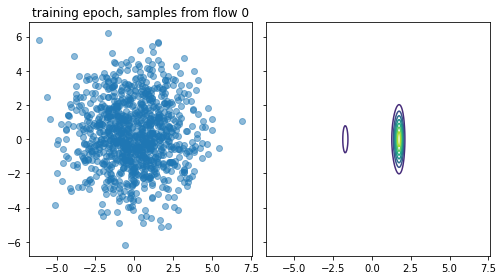

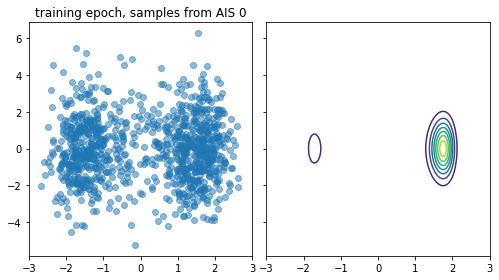

loss: -8.636902346176349,   log_p_x_post_AIS 6.949969715806913, ESS 0.1028478781722441:  25%|█████████████▊                                         | 250/1000 [12:14<35:41,  2.85s/it]

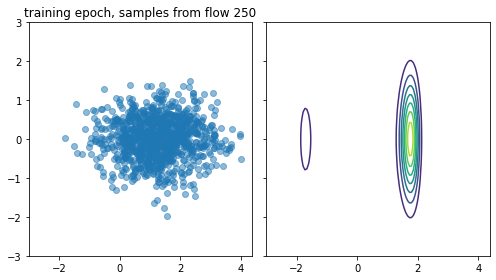

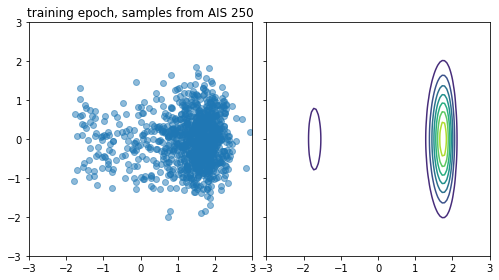

loss: -6.732600829998647,   log_p_x_post_AIS 9.273463574749657, ESS 0.05013702246174736:  50%|███████████████████████████                           | 500/1000 [24:20<23:23,  2.81s/it]

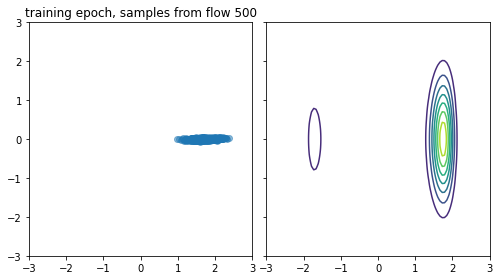

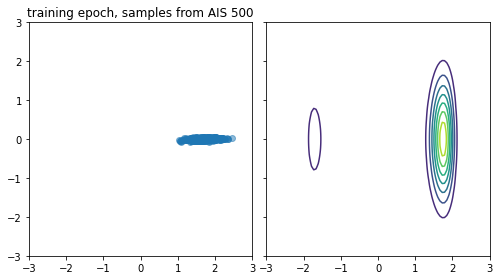

loss: -5.9362114243958235,   log_p_x_post_AIS 9.363317573580643, ESS 0.05812039492322568:  75%|███████████████████████████████████████▊             | 750/1000 [36:24<12:19,  2.96s/it]

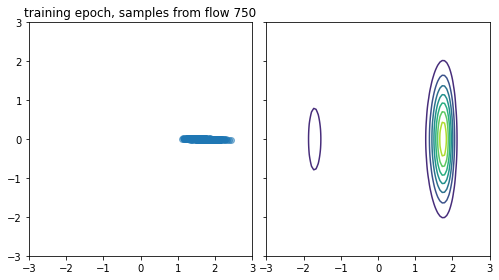

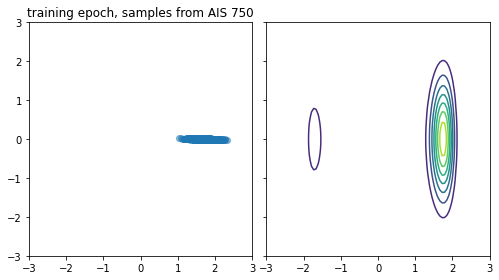

loss: -5.920112012969603,   log_p_x_post_AIS 9.34954559782344, ESS 0.07747009209835531: 100%|██████████████████████████████████████████████████████| 1000/1000 [48:30<00:00,  2.91s/it]


In [35]:
history = tester.train(1000, batch_size=int(1e3), intermediate_plots=True, n_plots=4, plotting_func=plotter)

In [36]:
expectation, info_dict = tester.AIS_train.calculate_expectation(n_samples_expectation,
                                                                    expectation_function=expectation_function,
                                                                             batch_size=int(1e3))
print(info_dict['effective_sample_size'].item() / n_samples_expectation)

0.008081818500937362


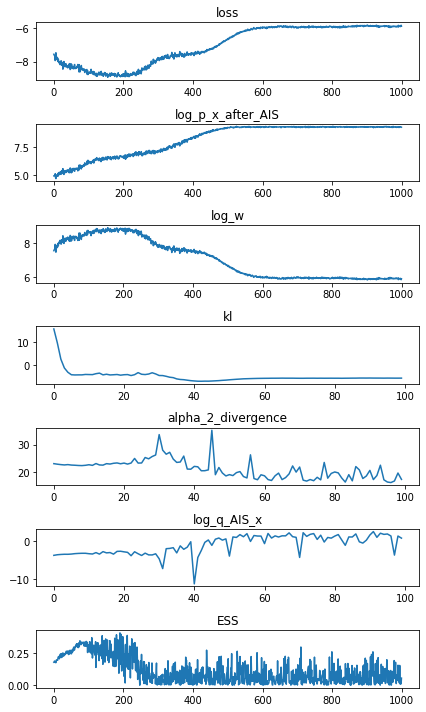

In [37]:
plot_history(history)

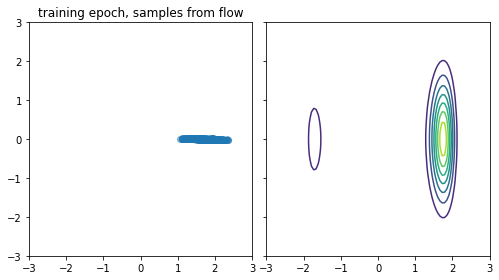

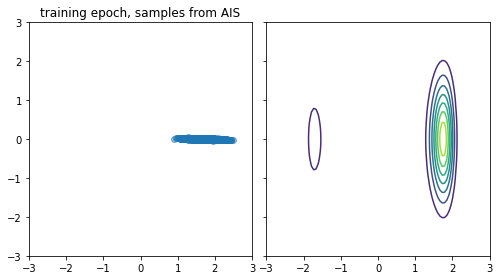

In [38]:
plot_samples_vs_contours_many_well(tester, n_samples=1000,
                                      title=f"training epoch, samples from flow")
plot_samples_vs_contours_many_well(tester, n_samples=None,
                                      title=f"training epoch, samples from AIS",
                                      samples_q=info_dict["samples"])

# DReG, constant step size

In [45]:
learnt_sampler = FlowModel(x_dim=dim, scaling_factor=2.0, flow_type="RealNVP", n_flow_steps=60)
tester = AIS_trainer(target, learnt_sampler, loss_type="DReG", n_distributions=5, n_steps_transition_operator=5,
                    step_size=1.0, transition_operator="Metropolis", learnt_dist_kwargs={"lr": 1e-4},
                    anneal_step_size=False)

In [46]:
expectation_before, info_dict_before = tester.AIS_train.calculate_expectation(n_samples_expectation,
                                                                    expectation_function=expectation_function,
                                                                             batch_size=int(1e3))
print(info_dict_before['effective_sample_size'].item() / n_samples_expectation)

0.17912806690247124


  0%|                                                                                                                                                          | 0/300 [00:00<?, ?it/s]

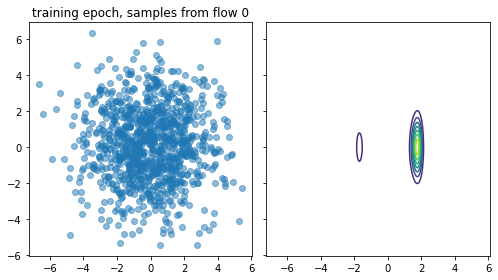

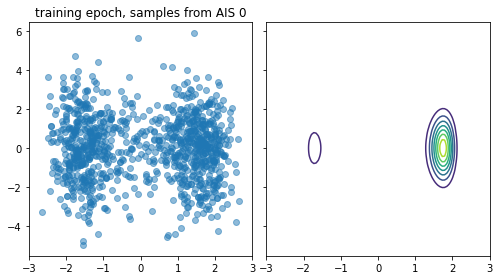

loss: -11.49877153689834,   log_p_x_post_AIS 5.503671178236369, ESS 0.2953315774916381:  25%|██████████████▎                                          | 75/300 [03:54<11:36,  3.09s/it]

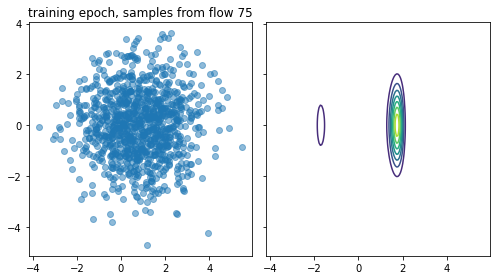

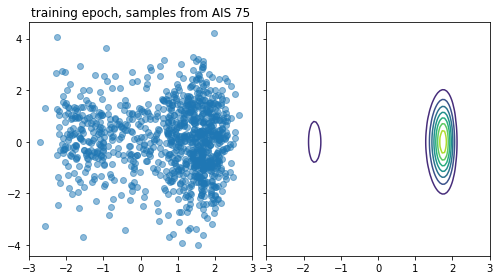

loss: -11.32193230102852,   log_p_x_post_AIS 6.067613547399954, ESS 0.3613936332973318:  50%|████████████████████████████                            | 150/300 [07:53<07:53,  3.15s/it]

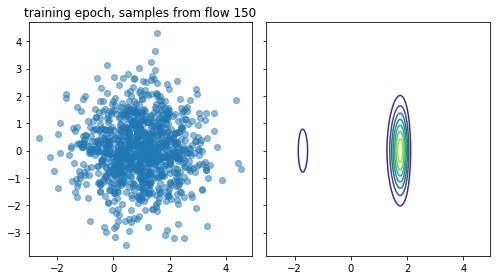

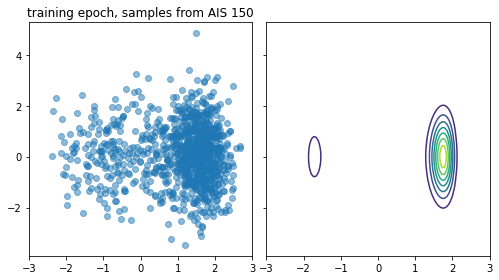

loss: -11.024760673485858,   log_p_x_post_AIS 5.915132947104805, ESS 0.26532096229563534:  75%|████████████████████████████████████████▌             | 225/300 [11:49<03:56,  3.16s/it]

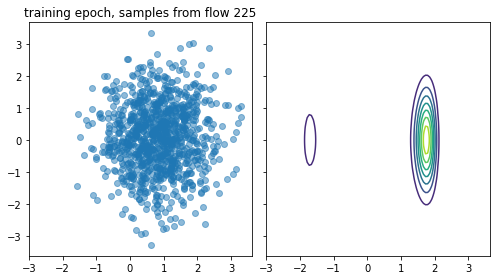

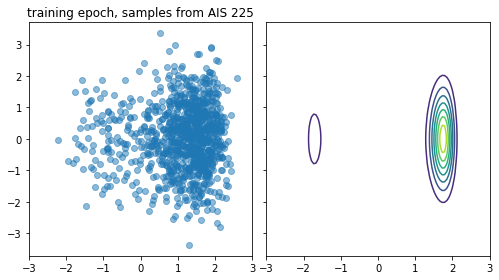

loss: -11.353118254238547,   log_p_x_post_AIS 5.9945890142179366, ESS 0.280540618086651: 100%|███████████████████████████████████████████████████████| 300/300 [15:46<00:00,  3.16s/it]


In [47]:
history = tester.train(300, batch_size=int(1e3), intermediate_plots=True, n_plots=4, plotting_func=plotter)

In [48]:
expectation, info_dict = tester.AIS_train.calculate_expectation(n_samples_expectation,
                                                                    expectation_function=expectation_function,
                                                                             batch_size=int(1e3))
print(info_dict['effective_sample_size'].item() / n_samples_expectation)

0.19172725760975368


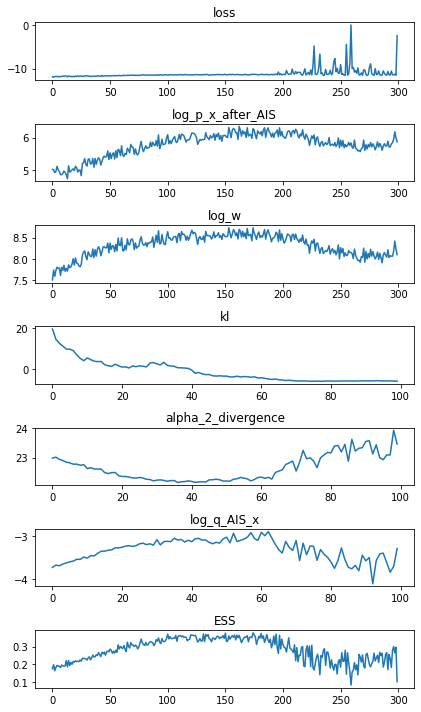

In [49]:
plot_history(history)

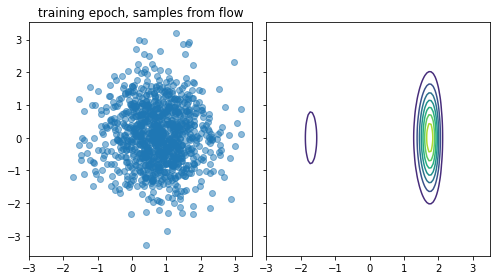

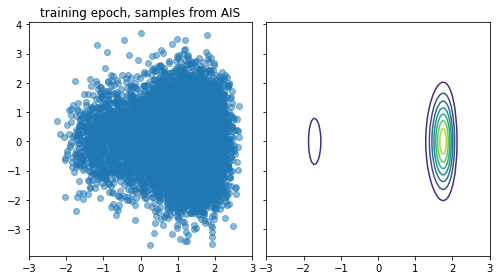

In [50]:
plot_samples_vs_contours_many_well(tester, n_samples=1000,
                                      title=f"training epoch, samples from flow")
plot_samples_vs_contours_many_well(tester, n_samples=None,
                                      title=f"training epoch, samples from AIS",
                                      samples_q=info_dict["samples"])

### Half step size

In [54]:
tester.AIS_train.transition_operator_class.step_size.data = torch.tensor(0.5)

  0%|                                                                                                                                                           | 0/50 [00:00<?, ?it/s]

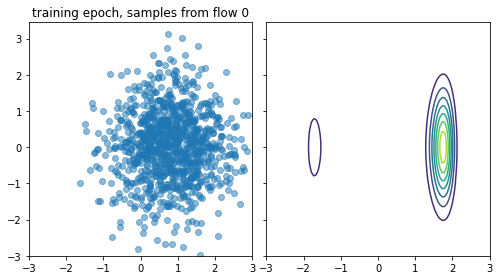

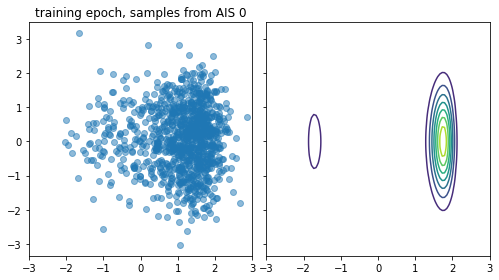

loss: -11.437214574364242,   log_p_x_post_AIS 6.0138309423077665, ESS 0.24693703073031892:  24%|█████████████▏                                         | 12/50 [00:41<01:58,  3.13s/it]

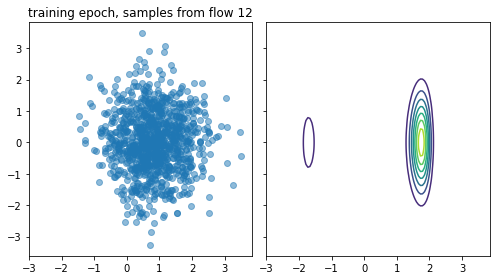

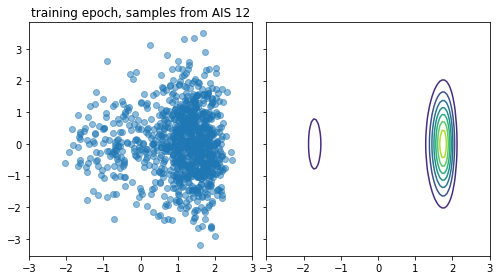

loss: -10.874447868064724,   log_p_x_post_AIS 5.67810020646504, ESS 0.1963552301234845:  48%|███████████████████████████▊                              | 24/50 [01:24<01:25,  3.28s/it]

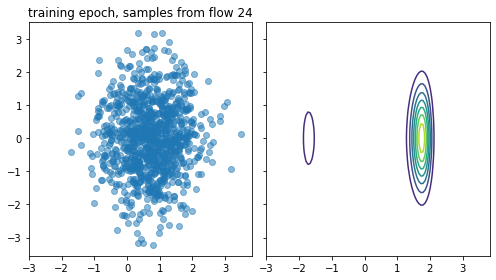

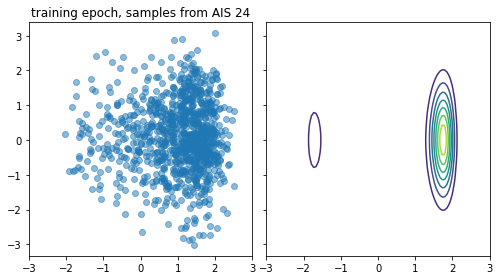

loss: -11.444428224228854,   log_p_x_post_AIS 5.903458225996839, ESS 0.28403555227898214:  72%|████████████████████████████████████████▎               | 36/50 [02:45<01:29,  6.36s/it]

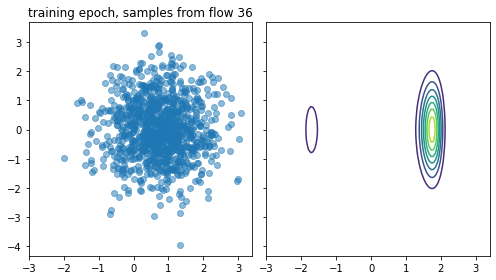

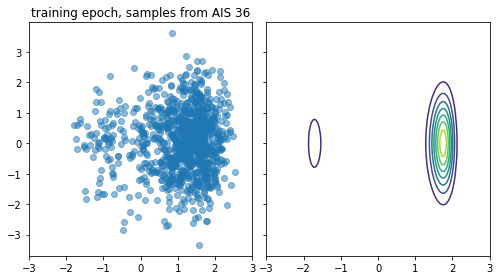

loss: -10.702005284519455,   log_p_x_post_AIS 5.829208239659296, ESS 0.20189972309563092:  96%|█████████████████████████████████████████████████████▊  | 48/50 [03:54<00:11,  5.63s/it]

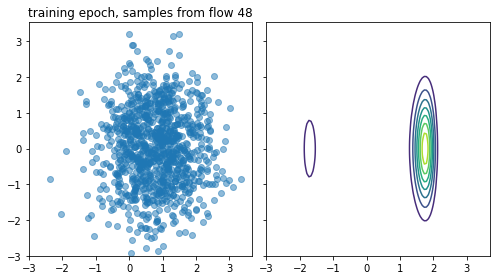

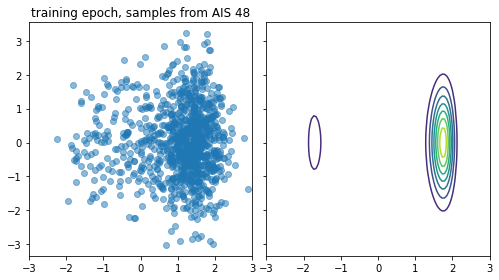

loss: -11.395550020786288,   log_p_x_post_AIS 5.904657815493976, ESS 0.27913961773346324: 100%|████████████████████████████████████████████████████████| 50/50 [04:01<00:00,  4.83s/it]


In [55]:
history = tester.train(50, batch_size=int(1e3), intermediate_plots=True, n_plots=4, plotting_func=plotter)

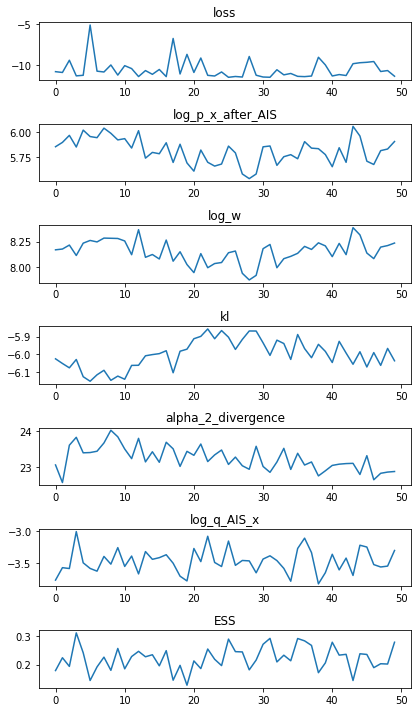

In [57]:
plot_history(history)

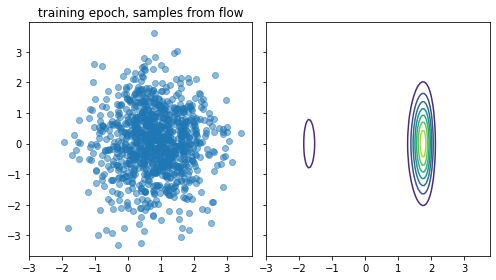

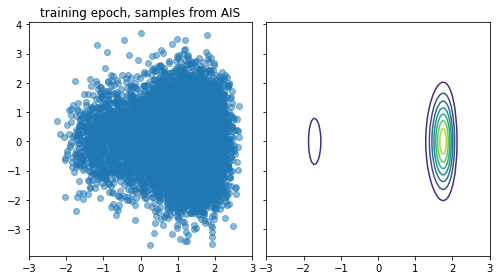

In [56]:
plot_samples_vs_contours_many_well(tester, n_samples=1000,
                                      title=f"training epoch, samples from flow")
plot_samples_vs_contours_many_well(tester, n_samples=None,
                                      title=f"training epoch, samples from AIS",
                                      samples_q=info_dict["samples"])

  0%|                                                                                                                                                          | 0/100 [00:00<?, ?it/s]

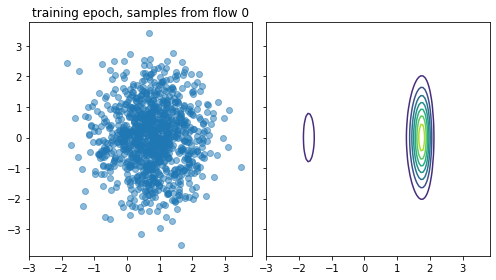

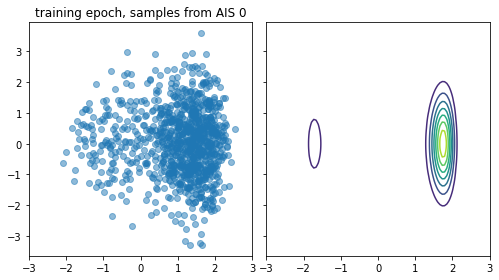

loss: -11.388536610533116,   log_p_x_post_AIS 5.843203463353001, ESS 0.3148628038803892:  25%|██████████████                                          | 25/100 [02:01<05:37,  4.50s/it]

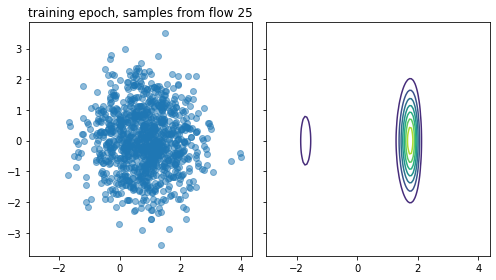

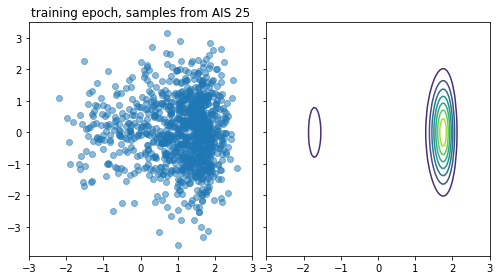

loss: -11.432409687123863,   log_p_x_post_AIS 5.90842028133558, ESS 0.28450835258254303:  50%|████████████████████████████                            | 50/100 [04:00<04:07,  4.96s/it]

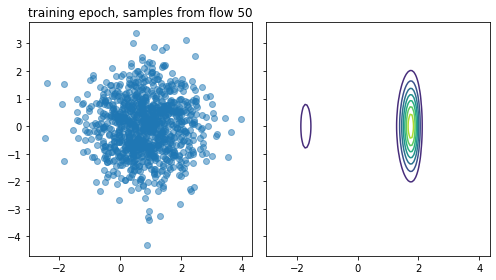

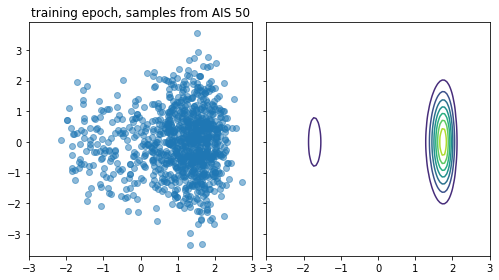

loss: -11.393055012000056,   log_p_x_post_AIS 6.106204899989245, ESS 0.3626368981800373:  75%|██████████████████████████████████████████              | 75/100 [06:01<01:59,  4.80s/it]

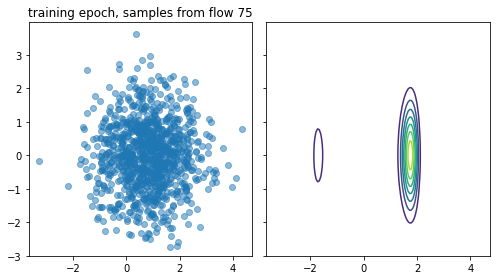

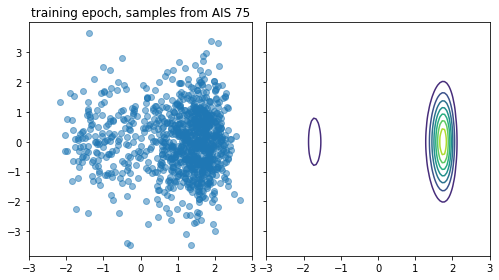

loss: -11.3346565584981,   log_p_x_post_AIS 5.904957909853428, ESS 0.31547541939397805: 100%|████████████████████████████████████████████████████████| 100/100 [08:07<00:00,  4.87s/it]


In [58]:
history = tester.train(100, batch_size=int(1e3), intermediate_plots=True, n_plots=4, plotting_func=plotter)

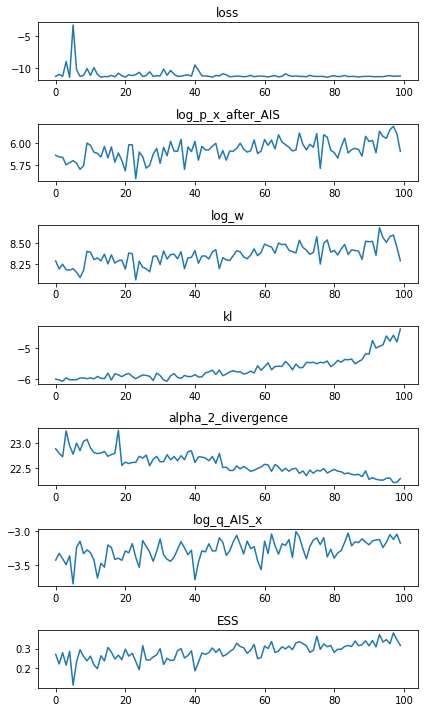

In [59]:
plot_history(history)

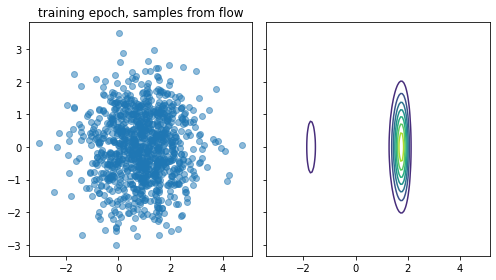

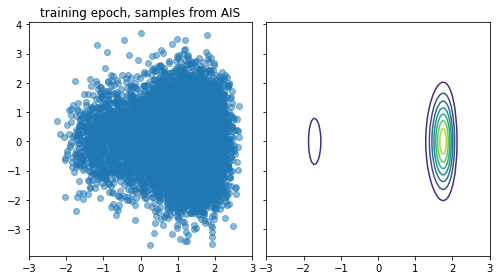

In [60]:
plot_samples_vs_contours_many_well(tester, n_samples=1000,
                                      title=f"training epoch, samples from flow")
plot_samples_vs_contours_many_well(tester, n_samples=None,
                                      title=f"training epoch, samples from AIS",
                                      samples_q=info_dict["samples"])

  0%|                                                                                                                                                          | 0/100 [00:00<?, ?it/s]

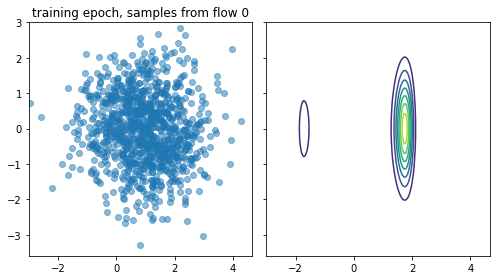

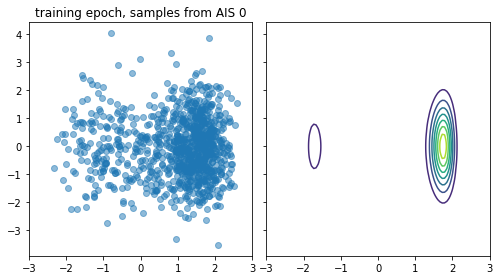

loss: -11.3213020547634,   log_p_x_post_AIS 6.158907531176043, ESS 0.36519087859820554:  25%|██████████████▎                                          | 25/100 [01:22<03:50,  3.07s/it]

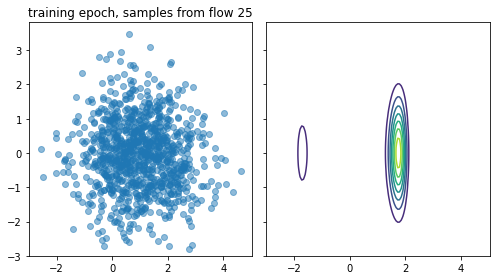

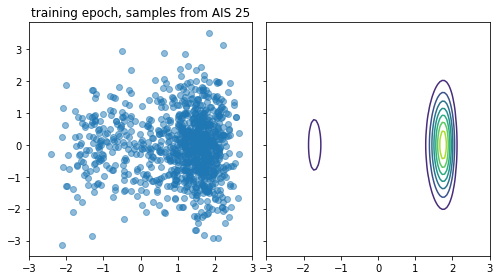

loss: -11.38573804894626,   log_p_x_post_AIS 6.1269378043470875, ESS 0.355352706542854:  50%|████████████████████████████▌                            | 50/100 [02:43<02:43,  3.27s/it]

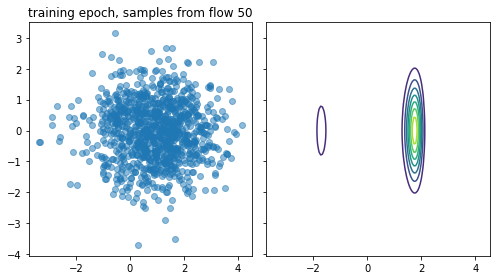

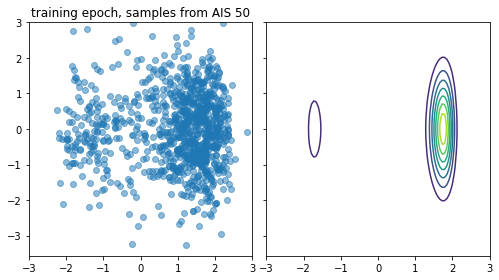

loss: -11.323559981812814,   log_p_x_post_AIS 5.912003114720132, ESS 0.34970546509219524:  75%|█████████████████████████████████████████▎             | 75/100 [04:03<01:22,  3.30s/it]

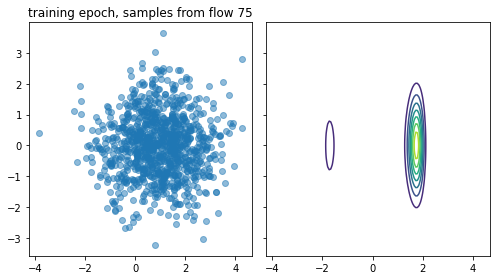

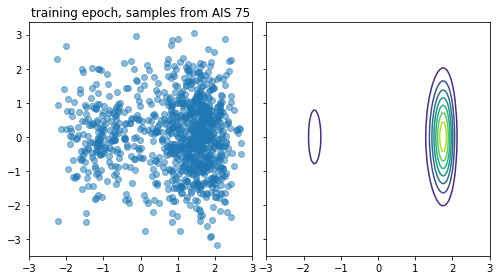

loss: -11.298231990062515,   log_p_x_post_AIS 6.085015441413708, ESS 0.35041302570278443: 100%|██████████████████████████████████████████████████████| 100/100 [05:23<00:00,  3.23s/it]


In [61]:
history = tester.train(100, batch_size=int(1e3), intermediate_plots=True, n_plots=4, plotting_func=plotter)

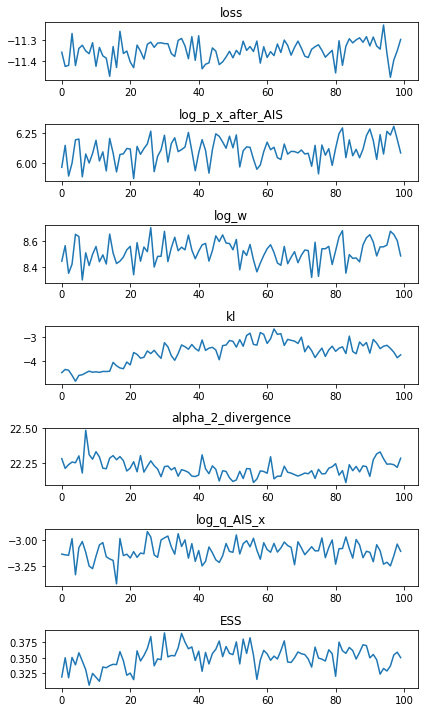

In [62]:
plot_history(history)

# Half step size again

In [64]:
tester.AIS_train.transition_operator_class.step_size.data = torch.tensor(0.25)

  0%|                                                                                                                                                          | 0/100 [00:00<?, ?it/s]

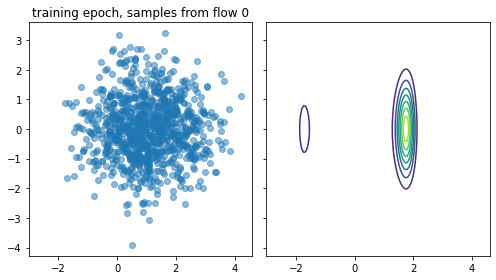

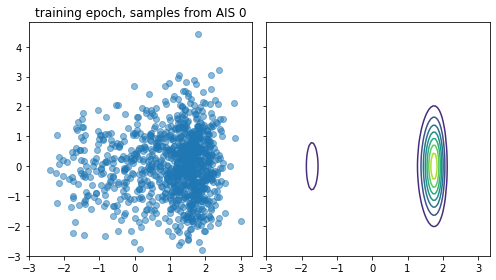

loss: -11.481903473821413,   log_p_x_post_AIS 5.887405427581463, ESS 0.3534830361538795:  25%|██████████████                                          | 25/100 [01:30<04:03,  3.25s/it]

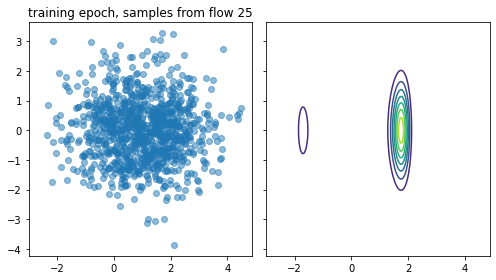

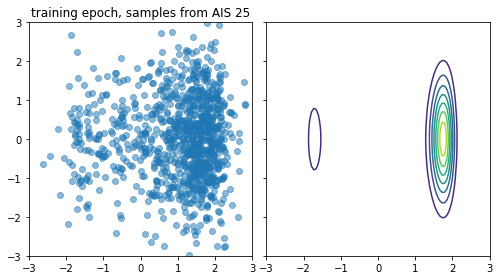

loss: -11.370833692247414,   log_p_x_post_AIS 5.879841548120269, ESS 0.3643430370700441:  50%|████████████████████████████                            | 50/100 [02:49<02:35,  3.11s/it]

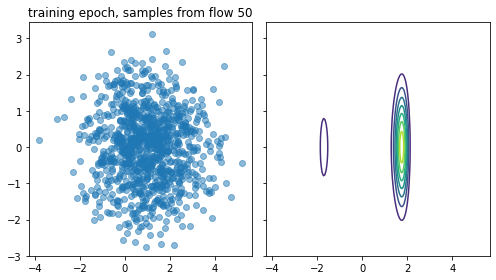

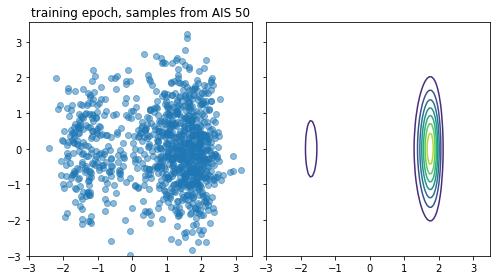

loss: -11.346800850656079,   log_p_x_post_AIS 5.742732068682281, ESS 0.3444171242367164:  75%|██████████████████████████████████████████              | 75/100 [04:14<01:28,  3.55s/it]

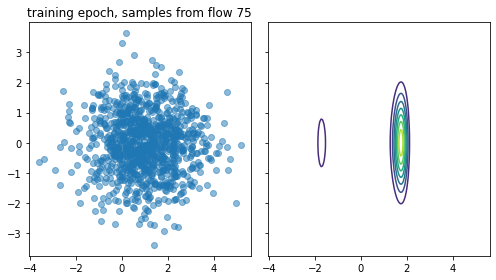

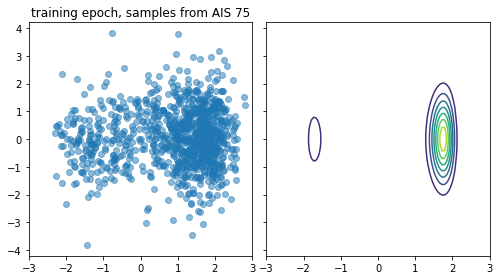

loss: -11.391282716237837,   log_p_x_post_AIS 5.735953502115632, ESS 0.33257443925820446: 100%|██████████████████████████████████████████████████████| 100/100 [05:42<00:00,  3.43s/it]


In [65]:
history = tester.train(100, batch_size=int(1e3), intermediate_plots=True, n_plots=4, plotting_func=plotter)

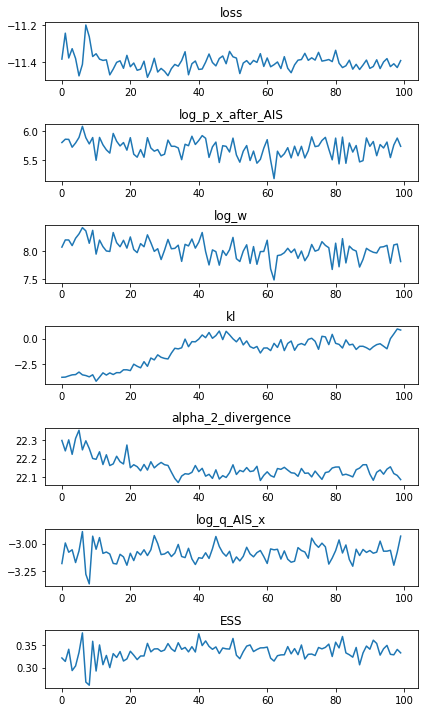

In [66]:
plot_history(history)

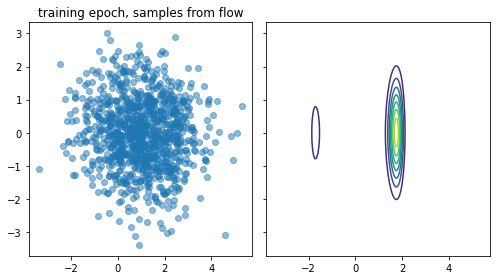

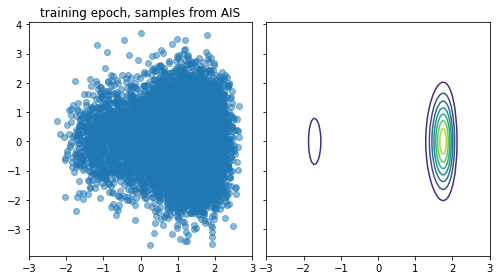

In [67]:
plot_samples_vs_contours_many_well(tester, n_samples=1000,
                                      title=f"training epoch, samples from flow")
plot_samples_vs_contours_many_well(tester, n_samples=None,
                                      title=f"training epoch, samples from AIS",
                                      samples_q=info_dict["samples"])

In [68]:
expectation, info_dict = tester.AIS_train.calculate_expectation(n_samples_expectation,
                                                                    expectation_function=expectation_function,
                                                                             batch_size=int(1e3))
print(info_dict['effective_sample_size'].item() / n_samples_expectation)

0.3391260048256235


  0%|                                                                                                                                                          | 0/100 [00:00<?, ?it/s]

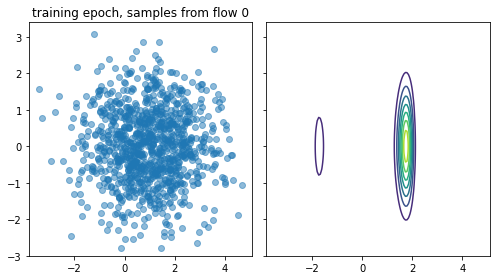

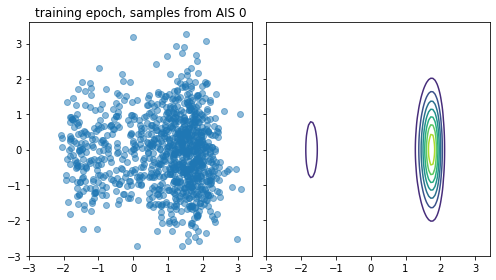

loss: -11.386215786508032,   log_p_x_post_AIS 5.566302849027729, ESS 0.32398115520032483:  25%|█████████████▊                                         | 25/100 [01:27<04:14,  3.40s/it]

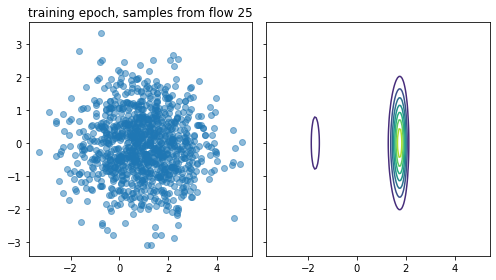

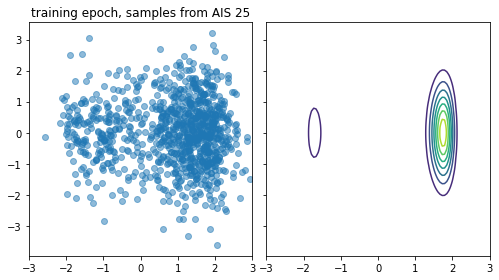

loss: -11.469661950447879,   log_p_x_post_AIS 5.598273936758814, ESS 0.3468411582448469:  50%|████████████████████████████                            | 50/100 [02:54<02:55,  3.51s/it]

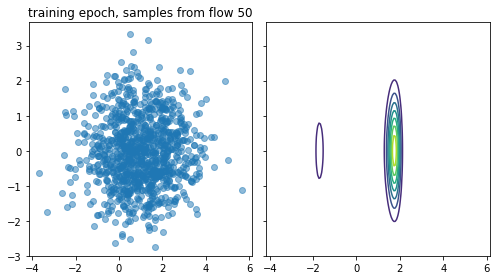

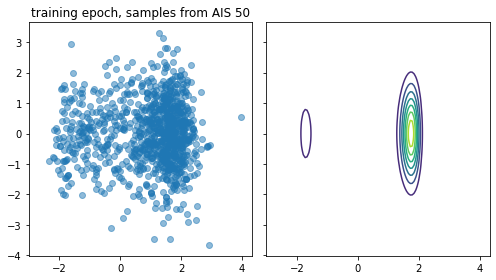

loss: -11.410677408684158,   log_p_x_post_AIS 5.600660489846356, ESS 0.33142180960511236:  75%|█████████████████████████████████████████▎             | 75/100 [04:16<01:17,  3.10s/it]

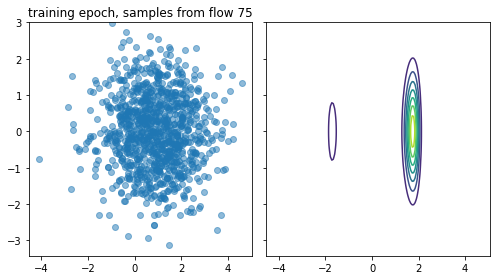

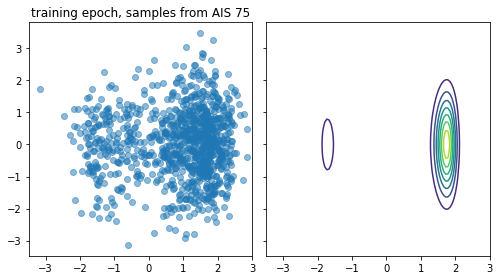

loss: -11.411114201870676,   log_p_x_post_AIS 5.792636350046969, ESS 0.34890733161415255: 100%|██████████████████████████████████████████████████████| 100/100 [05:33<00:00,  3.34s/it]


In [69]:
history = tester.train(100, batch_size=int(1e3), intermediate_plots=True, n_plots=4, plotting_func=plotter)

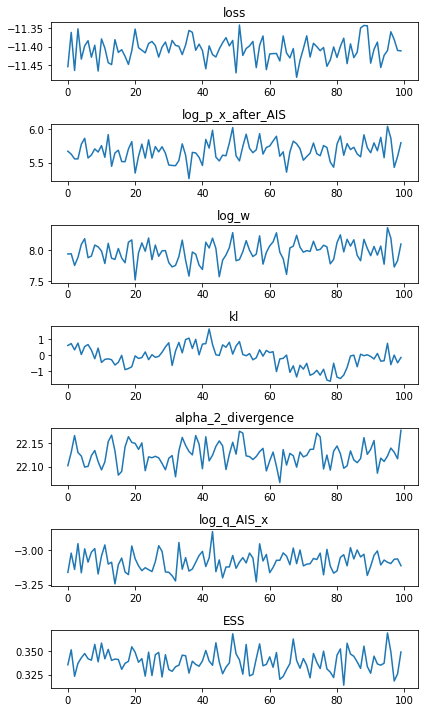

In [70]:
plot_history(history)

  0%|                                                                                                                                                          | 0/100 [00:00<?, ?it/s]

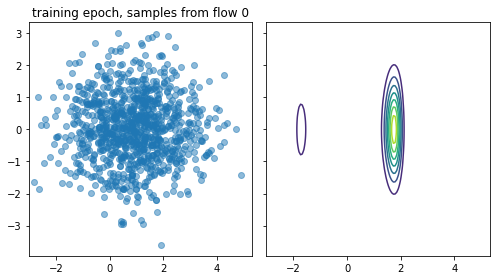

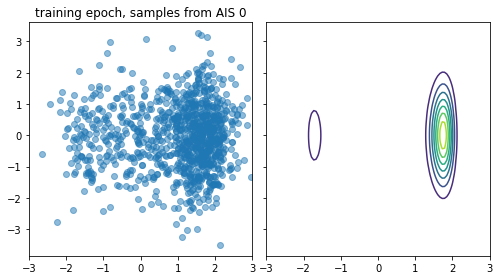

loss: -11.385000111120663,   log_p_x_post_AIS 5.785521377772743, ESS 0.340585567878886:  25%|██████████████▎                                          | 25/100 [01:26<04:14,  3.40s/it]

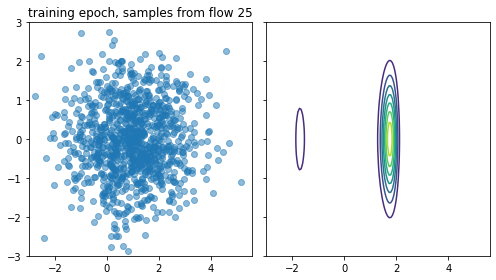

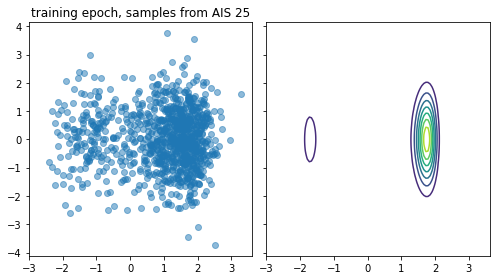

loss: -11.386311958414598,   log_p_x_post_AIS 5.5789261639892995, ESS 0.3476908348443058:  50%|███████████████████████████▌                           | 50/100 [02:49<02:40,  3.20s/it]

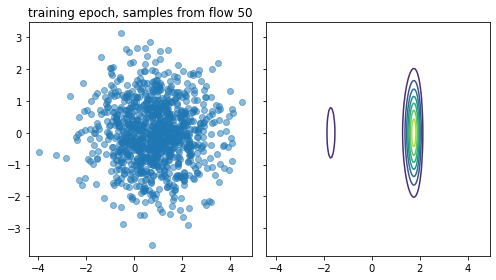

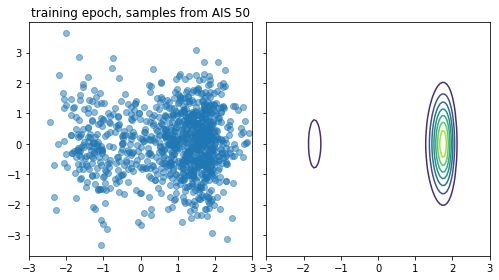

loss: -11.402881321053865,   log_p_x_post_AIS 5.659629717494891, ESS 0.32319988517373294:  75%|█████████████████████████████████████████▎             | 75/100 [04:16<01:27,  3.50s/it]

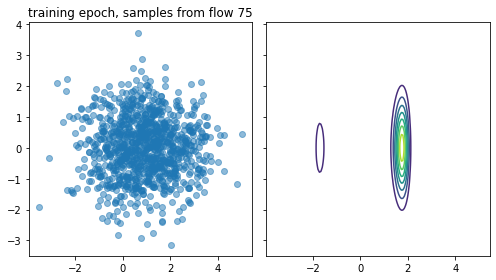

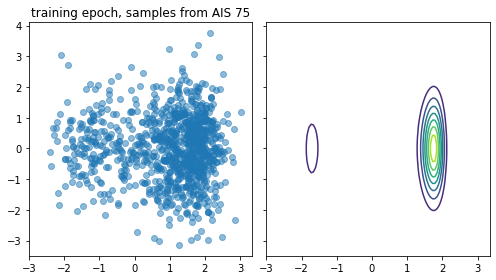

loss: -11.403680994557973,   log_p_x_post_AIS 5.970025998616153, ESS 0.3783107690175902: 100%|███████████████████████████████████████████████████████| 100/100 [05:39<00:00,  3.40s/it]


In [71]:
history = tester.train(100, batch_size=int(1e3), intermediate_plots=True, n_plots=4, plotting_func=plotter)

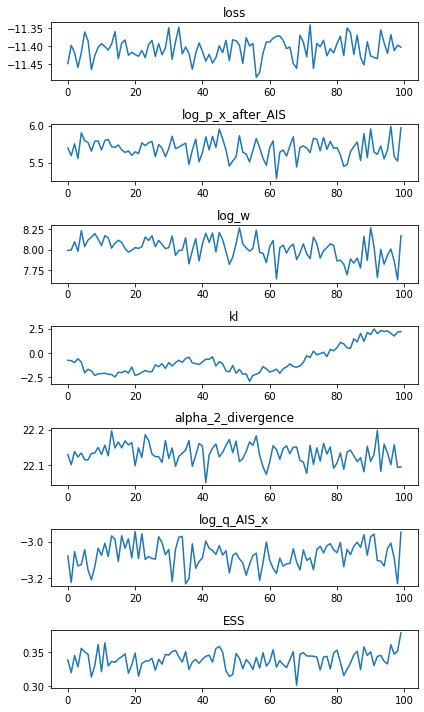

In [72]:
plot_history(history)

In [74]:
expectation, info_dict = tester.AIS_train.calculate_expectation(n_samples_expectation,
                                                                    expectation_function=expectation_function,
                                                                             batch_size=int(1e3))
print(info_dict['effective_sample_size'].item() / n_samples_expectation)

0.3349755378320135


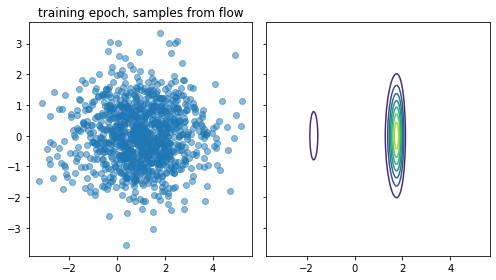

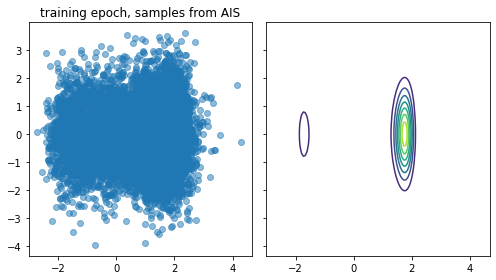

In [76]:
plot_samples_vs_contours_many_well(tester, n_samples=1000,
                                      title=f"training epoch, samples from flow")
plot_samples_vs_contours_many_well(tester, n_samples=None,
                                      title=f"training epoch, samples from AIS",
                                      samples_q=info_dict["samples"])

# Make smaller again

In [77]:
tester.AIS_train.transition_operator_class.step_size.data = torch.tensor(0.1)

  0%|                                                                                                                                                          | 0/100 [00:00<?, ?it/s]

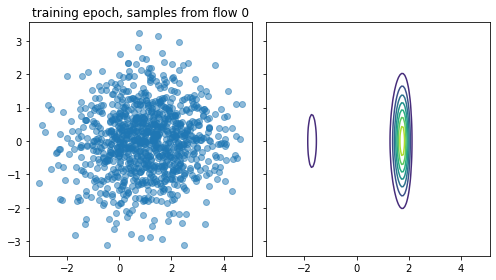

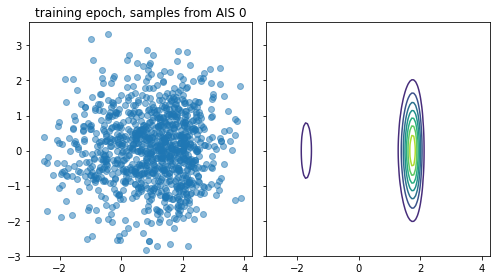

loss: -11.59857986496185,   log_p_x_post_AIS 3.216985555287737, ESS 0.26589137601195695:  25%|██████████████                                          | 25/100 [01:21<03:53,  3.11s/it]

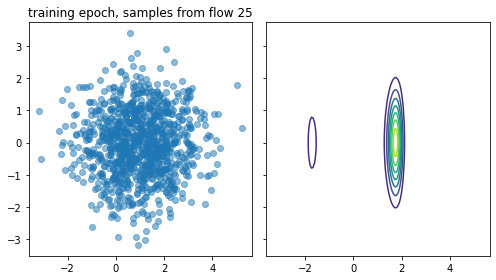

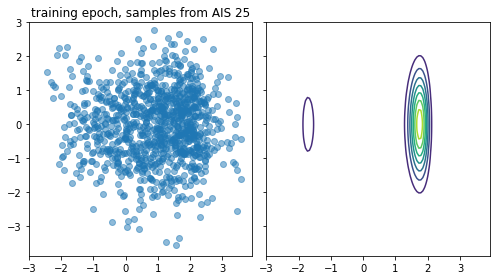

loss: -11.559290261321161,   log_p_x_post_AIS 3.091192552986649, ESS 0.2700259795005039:  50%|████████████████████████████                            | 50/100 [02:39<02:39,  3.20s/it]

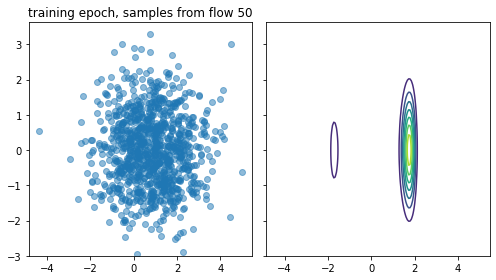

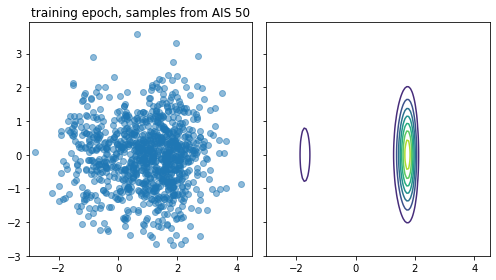

loss: -11.57898814852616,   log_p_x_post_AIS 3.3409836952745207, ESS 0.2730346621270582:  75%|██████████████████████████████████████████              | 75/100 [03:56<01:16,  3.06s/it]

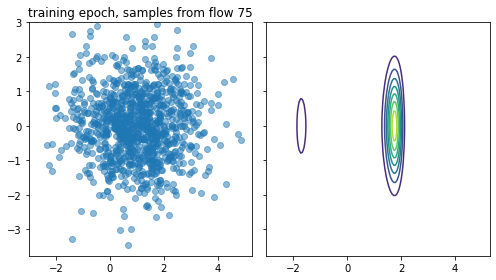

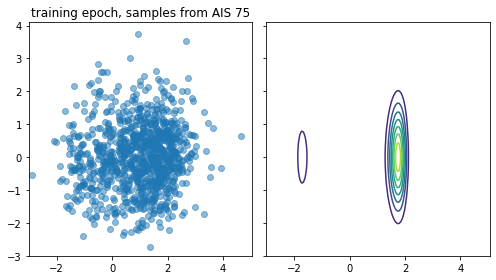

loss: -11.544362222957105,   log_p_x_post_AIS 3.366097584421198, ESS 0.27357735018469087: 100%|██████████████████████████████████████████████████████| 100/100 [05:18<00:00,  3.19s/it]


In [78]:
history = tester.train(100, batch_size=int(1e3), intermediate_plots=True, n_plots=4, plotting_func=plotter)

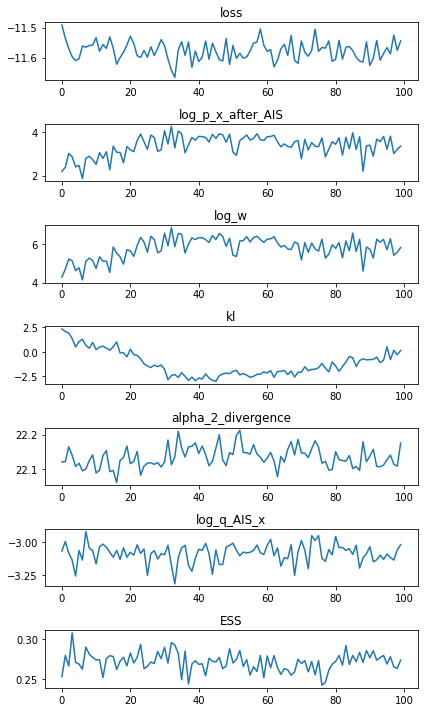

In [79]:
plot_history(history)

  0%|                                                                                                                                                          | 0/200 [00:00<?, ?it/s]

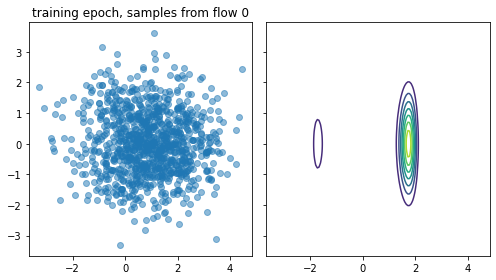

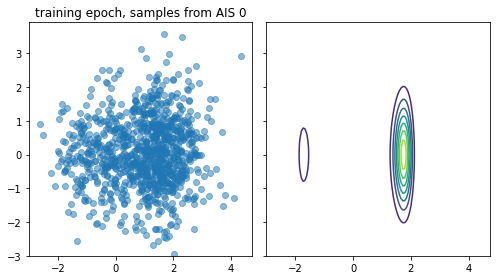

loss: -11.606636255767729,   log_p_x_post_AIS 3.6298353663700547, ESS 0.2751555030426763:  25%|█████████████▊                                         | 50/200 [02:36<07:10,  2.87s/it]

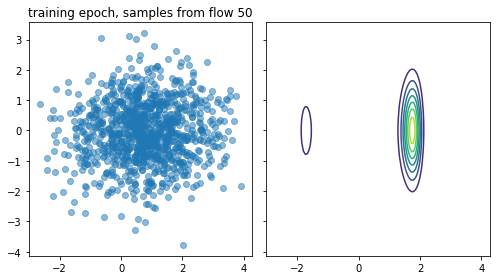

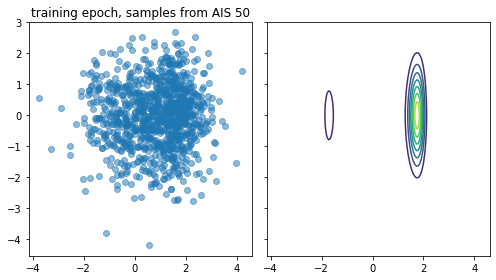

loss: -11.590493401848608,   log_p_x_post_AIS 3.6571458750914325, ESS 0.270476219091749:  50%|███████████████████████████▌                           | 100/200 [05:13<05:24,  3.24s/it]

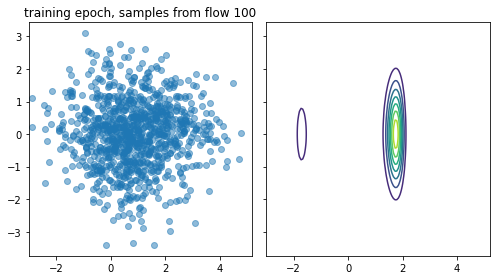

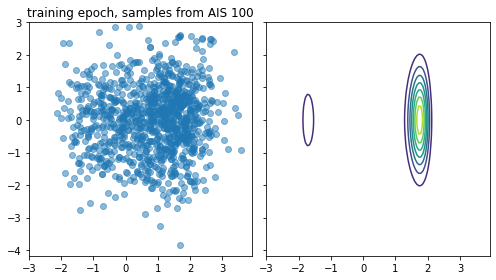

loss: -11.57705048294094,   log_p_x_post_AIS 3.5703813774434314, ESS 0.28135829489362596:  75%|████████████████████████████████████████▌             | 150/200 [07:42<02:27,  2.96s/it]

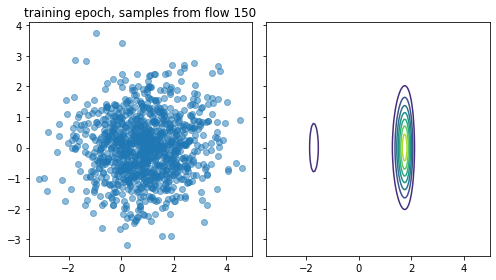

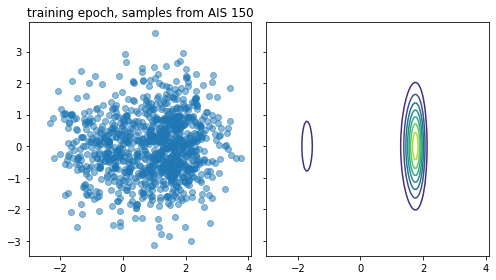

loss: -11.619577764443386,   log_p_x_post_AIS 3.798844429885624, ESS 0.2600139400803255: 100%|███████████████████████████████████████████████████████| 200/200 [10:16<00:00,  3.08s/it]


In [80]:
history = tester.train(200, batch_size=int(1e3), intermediate_plots=True, n_plots=4, plotting_func=plotter)

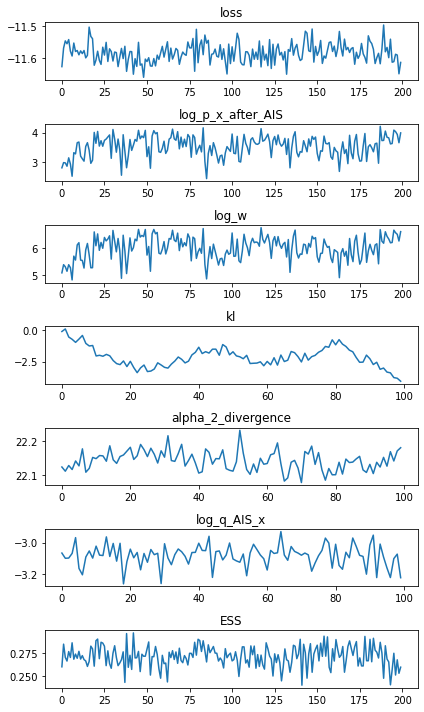

In [81]:
plot_history(history)